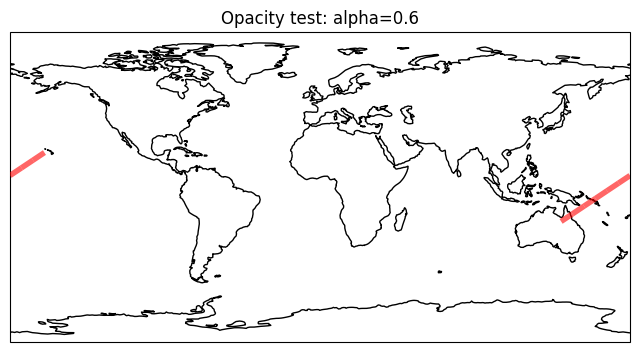

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_line_on_map(ax, lons, lats, **kwargs):
    """
    Plot a polyline on a map while safely handling dateline wrap-around.

    Supports list, tuple, numpy array, or pandas Series inputs.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Target axis (typically cartopy GeoAxes).
    lons : array-like
        Sequence of longitudes (degrees).
    lats : array-like
        Sequence of latitudes (degrees).
    **kwargs :
        Additional keyword arguments passed to ax.plot().
    """

    # ------------------------------------------------------------------
    # Convert inputs to NumPy arrays for consistent indexing behavior
    # ------------------------------------------------------------------
    lons = np.asarray(lons)
    lats = np.asarray(lats)

    # ------------------------------------------------------------------
    # Basic validation
    # ------------------------------------------------------------------
    if lons.shape != lats.shape:
        raise ValueError("Longitude and latitude arrays must have the same shape.")

    if lons.ndim != 1:
        raise ValueError("Longitude and latitude inputs must be 1D sequences.")

    # ------------------------------------------------------------------
    # Plot segment-by-segment using wrap-safe segment function
    # ------------------------------------------------------------------
    for i in range(len(lons) - 1):

        plot_line_segment_on_map(
            ax,
            lons[i],
            lons[i + 1],
            lats[i],
            lats[i + 1],
            **kwargs
        )


def plot_line_segment_on_map(ax, lon1, lon2, lat1, lat2, **kwargs):
    """
    Plot a line segment on a map while safely handling longitude wrap-around
    at the 0°/360° boundary.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Target axis (typically cartopy GeoAxes).
    lon1, lon2 : float
        Longitudes of the two endpoints (degrees).
    lat1, lat2 : float
        Latitudes of the two endpoints (degrees).
    **kwargs :
        Additional keyword arguments passed directly to ax.plot()
        (e.g., color, linewidth, linestyle, transform, zorder).
    """

    # ------------------------------------------------------------------
    # Normalize longitudes to 0–360 range to ensure consistency
    # This avoids ambiguity between -180–180 and 0–360 systems.
    # ------------------------------------------------------------------
    lon1_mod = lon1 % 360
    lon2_mod = lon2 % 360

    # ------------------------------------------------------------------
    # Compute longitudinal separation in normalized space.
    # If the separation exceeds 180°, the segment crosses the dateline.
    # ------------------------------------------------------------------
    dist = abs(lon2_mod - lon1_mod)

    if dist > 180:
        # --------------------------------------------------------------
        # The segment crosses the 0°/360° boundary.
        # We split it into two segments to prevent a long diagonal
        # artifact across the map.
        # --------------------------------------------------------------

        # Determine which boundary is crossed (0 or 360)
        if lon1_mod > lon2_mod:
            boundary1, boundary2 = 360, 0
        else:
            boundary1, boundary2 = 0, 360

        # --------------------------------------------------------------
        # Compute interpolation factor t for linear interpolation
        # along longitude to find latitude at boundary crossing.
        # --------------------------------------------------------------
        t = (boundary1 - lon1_mod) / (lon2_mod - lon1_mod)

        # Interpolated latitude at boundary
        lat_boundary = lat1 + t * (lat2 - lat1)

        # --------------------------------------------------------------
        # Plot first segment: point1 → boundary
        # --------------------------------------------------------------
        ax.plot(
            [lon1_mod, boundary1],
            [lat1, lat_boundary],
            **kwargs
        )

        # --------------------------------------------------------------
        # Plot second segment: boundary → point2
        # --------------------------------------------------------------
        ax.plot(
            [boundary2, lon2_mod],
            [lat_boundary, lat2],
            **kwargs
        )

    else:
        # --------------------------------------------------------------
        # No wrap-around: plot directly
        # --------------------------------------------------------------
        ax.plot(
            [lon1_mod, lon2_mod],
            [lat1, lat2],
            **kwargs
        )

# Create synthetic data
lons = np.linspace(140, 200, 10)
lats = np.linspace(-20, 20, 10)

# Create figure
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()
ax.coastlines()

# --------------------------------------------------
# 1. Plot points FIRST
# --------------------------------------------------
# ax.scatter(
#     lons,
#     lats,
#     s=80,
#     color="black",
#     zorder=5,
#     transform=ccrs.PlateCarree()
# )

# --------------------------------------------------
# 2. Plot line SECOND with opacity
# --------------------------------------------------
plot_line_on_map(
    ax,
    lons,
    lats,
    color="red",
    linewidth=4,
    alpha=0.6,      # Try changing this to 1.0
    zorder=10,
    transform=ccrs.PlateCarree(),
      solid_capstyle="butt",
      solid_joinstyle="miter"
                 )
# ax.plot(
#     lons,
#     lats,
#     color="red",
#     linewidth=4,
#     alpha=0.6,      # Try changing this to 1.0
#     zorder=10,
#     transform=ccrs.PlateCarree()
# )

plt.title("Opacity test: alpha=0.6")
plt.show()
